<a href="https://colab.research.google.com/github/Joyuri1022/Cloud_Network_Group2/blob/main/DATS6450_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from typing import Dict, Any, List, Tuple, Optional
from huggingface_hub import login
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

from tqdm import tqdm
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
)

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_COSINE = True
DEFAULT_THRESHOLD = 0.8



CORPUS = [
    # ===== 1. Controversial / Binary Questions (1–3) =====
    "Is the Earth flat or is its roundness confirmed by scientific observation?",
    "Did humans truly land on the Moon, according to the historical evidence available?",
    "Is climate change primarily driven by human activity such as fossil fuel consumption?",

    # ===== 2. Scientific Misconceptions (4–6) =====
    "Do vaccines cause autism despite overwhelming medical research showing no connection?",
    "Is it true that humans use only ten percent of their brain capacity?",
    "Is astrology supported by scientific methodology or empirical validation?",

    # ===== 3. Descriptive Scenes (7–9) =====
    "A quiet river winds through a wide valley beneath towering snow covered mountains.",
    "Golden sunlight filtered through the old wooden cabin standing alone on the hillside.",
    "The bustling marketplace overflowed with bright colors, fragrant spices, and lively chatter.",

    # ===== 4. Scientific / Expository (10–12) =====
    "Quantum entanglement describes a correlation between particles that persists regardless of distance.",
    "Photosynthesis converts light energy into chemical energy inside specialized plant cells.",
    "Neural networks learn patterns by adjusting weights through repeated exposure to data.",

    # ===== 5. Narrative Sentences (13–15) =====
    "After the storm passed, the villagers gathered together to rebuild their damaged homes.",
    "She opened the ancient book and felt a warm glow spreading across the dusty pages.",
    "He hesitated at the crossroads, unsure which path would lead him toward a better life.",

    # ===== 6. Logical / Reasoning (16–18) =====
    "If all mammals are warm blooded and whales are mammals, then whales must be warm blooded.",
    "If a number is divisible by both two and three, then it must be divisible by six.",
    "If every student in a group passed the exam, then it follows that no student failed.",

    # ===== 7. Instructional / Explanatory Questions (19–21) =====
    "Explain the main differences between renewable and nonrenewable sources of energy.",
    "How does photosynthesis contribute to regulating the global carbon cycle?",
    "Describe how machine learning models improve through iterative training.",

    # ===== 8. Emotional / Expressive (22–24) =====
    "I felt overwhelming relief wash over me when I finally received the long awaited news.",
    "The film left me heartbroken yet strangely hopeful as the final scene faded to black.",
    "She looked out at the quiet night sky and felt a deep sense of peace settle within her.",

    # ===== 9. Conversational / Casual (25–27) =====
    "Hey, are you free later this afternoon to grab coffee and catch up?",
    "I'm thinking about buying a new laptop and could use some suggestions.",
    "Let me know if you want to join us for dinner tonight at the new restaurant.",

    # ===== 10. Technical / Domain Specific (28–30) =====
    "The algorithm converges once the gradient norm falls below the predefined threshold.",
    "The central bank raised interest rates to slow down inflationary pressure in the economy.",
    "Parallel computing reduces processing time by distributing tasks across multiple cores."
]



MODEL_SPECS = [
    {
        "id": "gpt2",
        "hf_name": "gpt2",
        "model_class": GPT2LMHeadModel,
        "tokenizer_class": GPT2Tokenizer,
        "max_length": 40,
        "trust_remote_code": False,
    },
    {
        "id": "qwen1_5",
        "hf_name": "Qwen/Qwen1.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen2_5",
        "hf_name": "Qwen/Qwen2.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen3",
        "hf_name": "Qwen/Qwen3-0.6B-base",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
]

In [3]:
# Load models and extract per layer tokens and compute cosine similarity
def load_model_and_tokenizer_from_spec(
    spec: Dict[str, Any],
    device: str = DEVICE,
):
    print(f"Loading model: {spec['hf_name']} on {device}...")
    tokenizer = spec["tokenizer_class"].from_pretrained(
        spec["hf_name"],
        trust_remote_code=spec.get("trust_remote_code", False),
    )
    model = spec["model_class"].from_pretrained(
        spec["hf_name"],
        output_hidden_states=True,
        trust_remote_code=spec.get("trust_remote_code", False),
    ).to(device)
    model.eval()

    return model, tokenizer

def extract_hidden_states(
    model,
    tokenizer,
    text: str,
    max_length: int = 40,
    device: str = DEVICE,
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Run the model on a single text and return:
    - hidden_arrays: list of [seq_len, hidden_dim] per layer
    - tokens: list of token strings
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states

    hidden_arrays = [h[0].cpu().numpy() for h in hidden_states]  # [seq_len, dim]
    token_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return hidden_arrays, tokens


def compute_similarity_matrix(
    hidden_state: np.ndarray,
    use_cosine: bool = True,
) -> np.ndarray:
    """
    hidden_state: [seq_len, hidden_dim]
    return: [seq_len, seq_len] similarity matrix
    """
    if use_cosine:
        norms = np.linalg.norm(hidden_state, axis=1, keepdims=True) + 1e-9
        hs_norm = hidden_state / norms
        sim = hs_norm @ hs_norm.T
    else:
        sim = hidden_state @ hidden_state.T
    return sim

In [4]:
def build_connectivity_graph(
    similarity_matrix: np.ndarray,
    threshold: float,
    tokens: List[str],
) -> nx.Graph:
    """
    Build an undirected graph where nodes are tokens,
    and edges connect pairs with similarity > threshold.
    """
    n = len(tokens)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, token=tokens[i])

    for i in range(n):
        for j in range(i + 1, n):
            sim_ij = similarity_matrix[i, j]
            if sim_ij > threshold:
                G.add_edge(i, j, weight=float(sim_ij))

    return G


def analyze_graph_structure(G: nx.Graph) -> Dict[str, Any]:
    """
    Return percolation-style observables:
    - component_sizes
    - largest_component_size
    - phi: largest_component_size / num_nodes
    - num_clusters
    - chi: mean cluster size excluding GCC
    """
    num_nodes = G.number_of_nodes()
    if num_nodes == 0:
        return {
            "component_sizes": [],
            "largest_component_size": 0,
            "phi": 0.0,
            "num_clusters": 0,
            "chi": 0.0,
        }

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_component_size = max(component_sizes)

    phi = largest_component_size / num_nodes
    num_clusters = len(component_sizes)

    finite_sizes = [s for s in component_sizes if s < largest_component_size]
    if len(finite_sizes) > 0:
        chi = float(np.mean(finite_sizes))
    else:
        chi = 0.0

    return {
        "component_sizes": component_sizes,
        "largest_component_size": largest_component_size,
        "phi": float(phi),
        "num_clusters": num_clusters,
        "chi": chi,
    }


def visualize_network(
    G: nx.Graph,
    tokens: List[str],
    layer_num: int,
    title: str = "",
    ax=None,
    layout: str = "spring",
):
    """
    Draw a token similarity graph with connected components colored differently.
    """
    if ax is None:
        ax = plt.gca()

    if len(G) == 0:
        ax.set_axis_off()
        ax.set_title(f"Layer {layer_num}: Empty graph")
        return

    if layout == "spring":
        pos = nx.spring_layout(G, seed=42, k=0.5)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_size = max(component_sizes)

    color_map = []
    for node in G.nodes():
        comp_idx = None
        for i, comp in enumerate(components):
            if node in comp:
                comp_idx = i
                break
        size = component_sizes[comp_idx]
        if size == largest_size and largest_size > 1:
            color_map.append("tab:red")
        else:
            color_map.append("tab:blue")

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=color_map, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
    labels = {i: tokens[i] for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    stats = analyze_graph_structure(G)
    phi = stats["phi"]
    num_clusters = stats["num_clusters"]
    largest_component_size = stats["largest_component_size"]
    n_nodes = G.number_of_nodes()

    if not title:
        title = (
            f"Layer {layer_num} | GCC: {largest_component_size}/{n_nodes} "
            f"(phi={phi:.2f}), clusters={num_clusters}"
        )
    ax.set_title(title, fontsize=9)
    ax.set_axis_off()


In [5]:
# Percolation wrappers (per text, over corpus, critical layer)

def percolation_stats_for_text(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    use_cosine: bool = USE_COSINE,
    max_length: int = 40,
) -> Dict[str, Any]:
    """
    For a given text and model:
    - extract hidden states,
    - build graphs per layer,
    - compute percolation stats per layer.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )

    layer_stats = []
    for layer_idx, hidden_state in enumerate(hidden_arrays):
        sim = compute_similarity_matrix(hidden_state, use_cosine=use_cosine)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)
        stats = analyze_graph_structure(G)
        stats["layer"] = layer_idx
        layer_stats.append(stats)

    return {
        "text": text,
        "tokens": tokens,
        "layer_stats": layer_stats,
    }

def phi_curve_for_single_text(
    model,
    tokenizer,
    text: str,
    threshold: float,
    max_length: int = 40,
):
    """
    for single text, return:
      - layers
      - phi_values: (|GCC| / N_tokens)
    """
    res = percolation_stats_for_text(
        model=model,
        tokenizer=tokenizer,
        text=text,
        threshold=threshold,
        max_length=max_length,
    )
    layer_stats = res["layer_stats"]
    layers = [s["layer"] for s in layer_stats]
    phi_values = [s["phi"] for s in layer_stats]
    return layers, phi_values


def aggregate_over_corpus(
    model,
    tokenizer,
    corpus: List[str],
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
) -> Tuple[Dict[int, Dict[str, float]], List[Dict[str, Any]]]:
    """
    Run percolation stats for each text, then aggregate per layer.
    """
    all_results: List[Dict[str, Any]] = []
    for text in tqdm(corpus, desc="Texts"):
        res = percolation_stats_for_text(
            model,
            tokenizer,
            text,
            threshold=threshold,
            max_length=max_length,
        )
        all_results.append(res)

    num_layers = len(all_results[0]["layer_stats"])
    aggregate: Dict[int, Dict[str, float]] = {}

    for layer_idx in range(num_layers):
        phi_vals = []
        num_clusters_vals = []
        chi_vals = []

        for res in all_results:
            s = res["layer_stats"][layer_idx]
            phi_vals.append(s["phi"])
            num_clusters_vals.append(s["num_clusters"])
            chi_vals.append(s["chi"])

        aggregate[layer_idx] = {
            "phi_mean": float(np.mean(phi_vals)),
            "phi_std": float(np.std(phi_vals)),
            "num_clusters_mean": float(np.mean(num_clusters_vals)),
            "num_clusters_std": float(np.std(num_clusters_vals)),
            "chi_mean": float(np.mean(chi_vals)),
            "chi_std": float(np.std(chi_vals)),
        }

    return aggregate, all_results


def aggregate_for_thresholds(
    model,
    tokenizer,
    corpus: List[str],
    thresholds: List[float],
    max_length: int = 40,
) -> Dict[float, Dict[int, Dict[str, float]]]:
    results_by_threshold: Dict[float, Dict[int, Dict[str, float]]] = {}

    for thr in thresholds:
        print(f"\n[Threshold = {thr}] Aggregating over corpus...")
        aggregate, _ = aggregate_over_corpus(
            model,
            tokenizer,
            corpus,
            threshold=thr,
            max_length=max_length,
        )
        results_by_threshold[thr] = aggregate

    return results_by_threshold


def find_critical_layer(
    aggregate_stats: Dict[int, Dict[str, float]],
    phi_threshold: float = 0.5,
    z_cut: float = 1.0,
) -> int | None:

    """
    Critical layer: layer l where
      - jump dphi(l) is "large": dphi(l) >= mean(dphi) + z_cut * std(dphi)
      - phi(l) >= phi_threshold
    Among all such layers, return the one with the largest dphi.
    """
    layers = sorted(aggregate_stats.keys())
    phi = np.array([aggregate_stats[l]["phi_mean"] for l in layers])

    if len(phi) < 2:
        return layers[0] if phi[0] >= phi_threshold else None

    # jumps from previous layer
    dphi = np.diff(phi)
    if np.all(dphi <= 0):
        return None

    # "large" jump threshold
    mean_dphi, std_dphi = dphi.mean(), dphi.std()

    # no variability -> no sharp transition
    if std_dphi < 1e-8:
        return None

    jump_min = mean_dphi + z_cut * std_dphi

    # candidate layers = upper endpoint of jump
    candidates = [
        i + 1 for i, dj in enumerate(dphi)
        if dj >= jump_min and phi[i + 1] >= phi_threshold
    ]
    if not candidates:
        return None

    # choose candidate with largest jump
    best = max(candidates, key=lambda idx: dphi[idx - 1])
    return best


# Single Prompt Token Clustering Visualization

In [6]:
def demo_single_text_networks(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
    layer_indices=None,
    num_key: int = 8,
):
    """
    Show how one text's token network evolves across selected layers
    in a single horizontal row.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )
    num_layers = len(hidden_arrays)

    # --- choose layers ---
    if layer_indices is not None:
        key_layers = sorted(
            set(l for l in layer_indices if 0 <= l < num_layers)
        )
        if len(key_layers) == 0:
            raise ValueError("layer_indices contains no valid layer indices.")
    else:
        key_layers = np.linspace(
            0, num_layers - 1, num_key, dtype=int
        ).tolist()
        key_layers = sorted(set(key_layers))

    n = len(key_layers)


    fig, axes = plt.subplots(1, n, figsize=(4.5 * n, 4.5),squeeze=False)

    for idx, layer in enumerate(key_layers):
        ax = axes[0, idx]

        hidden = hidden_arrays[layer]
        sim = compute_similarity_matrix(hidden, use_cosine=USE_COSINE)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)

        visualize_network(
            G,
            tokens,
            layer_num=layer,
            title=f"Layer {layer}",
            ax=ax,
        )

    fig.suptitle(
        "Token similarity networks across selected layers",
        fontsize=14,
        y=1.05,
    )

    fig.subplots_adjust(
        left=0.02,
        right=0.98,
        bottom=0.05,
        top=0.85,
        wspace=0.30,
    )

    plt.show()



=== MODEL: gpt2, THRESHOLD: 0.8 ===
Loading model: gpt2 on cpu...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

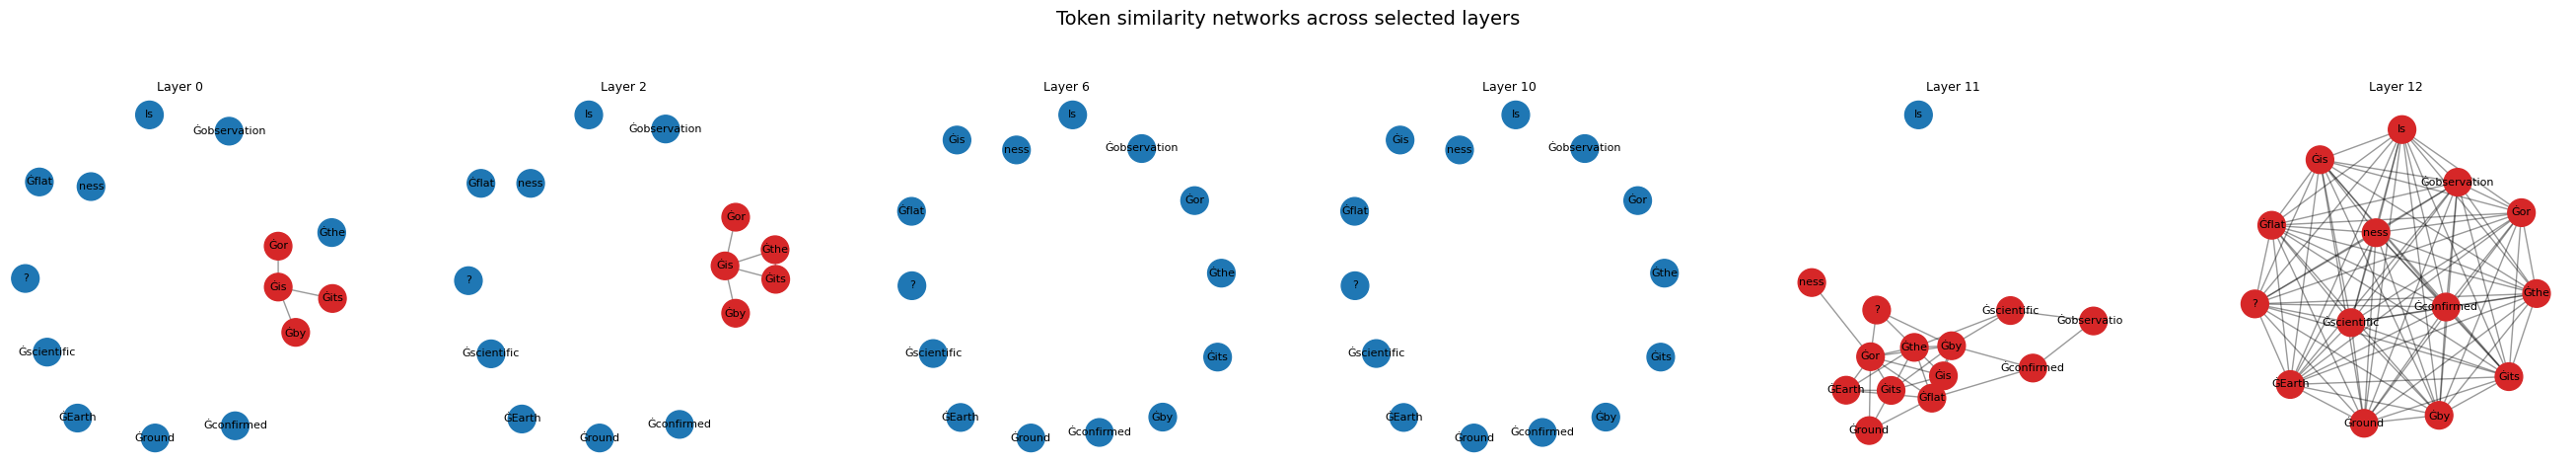


=== MODEL: qwen1_5, THRESHOLD: 0.8 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

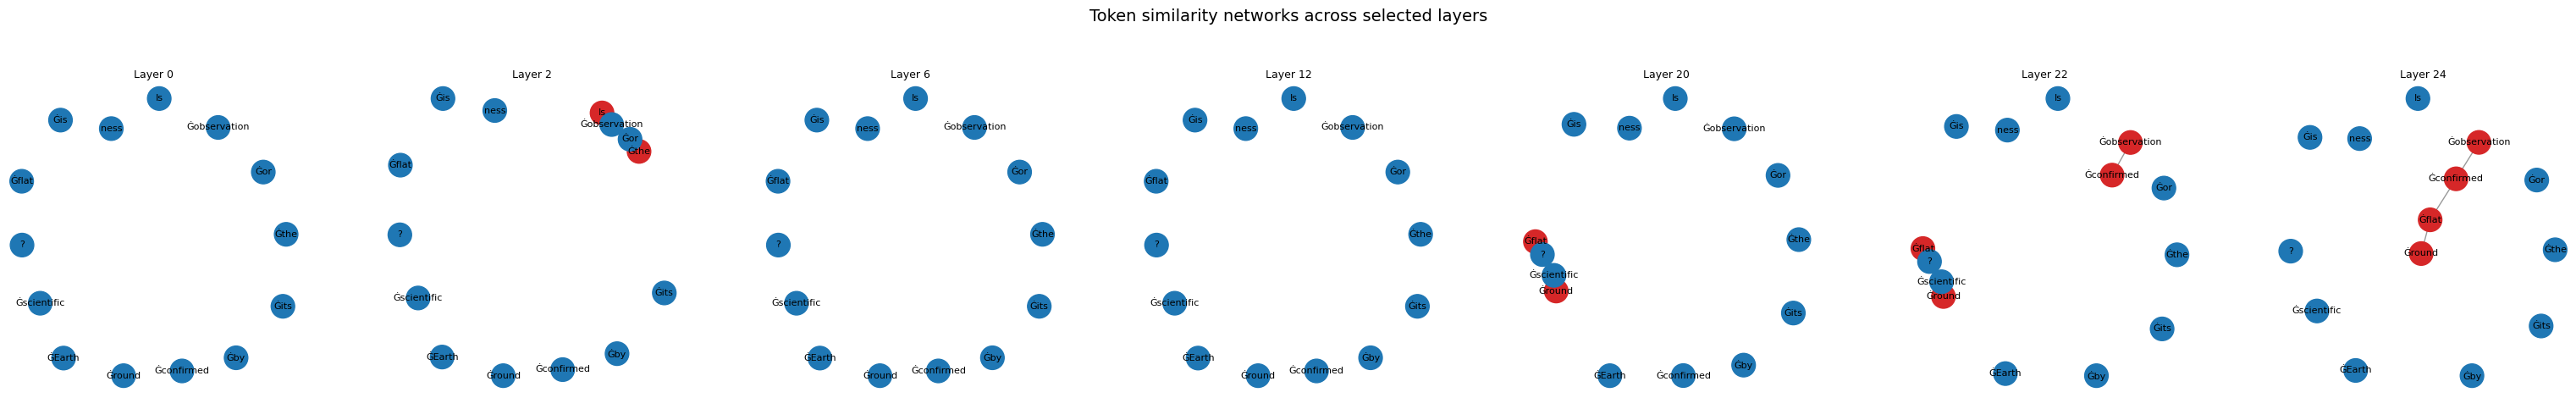


=== MODEL: qwen2_5, THRESHOLD: 0.8 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

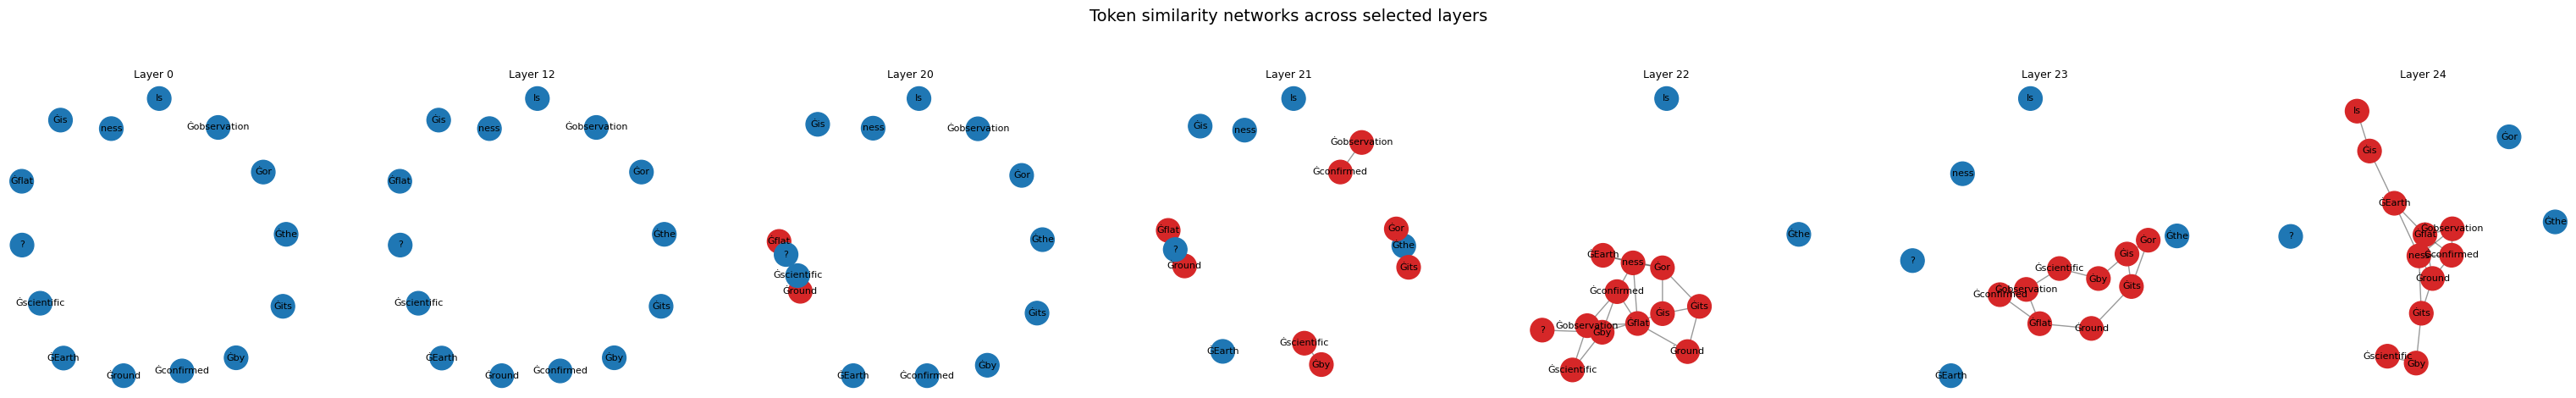


=== MODEL: qwen3, THRESHOLD: 0.8 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

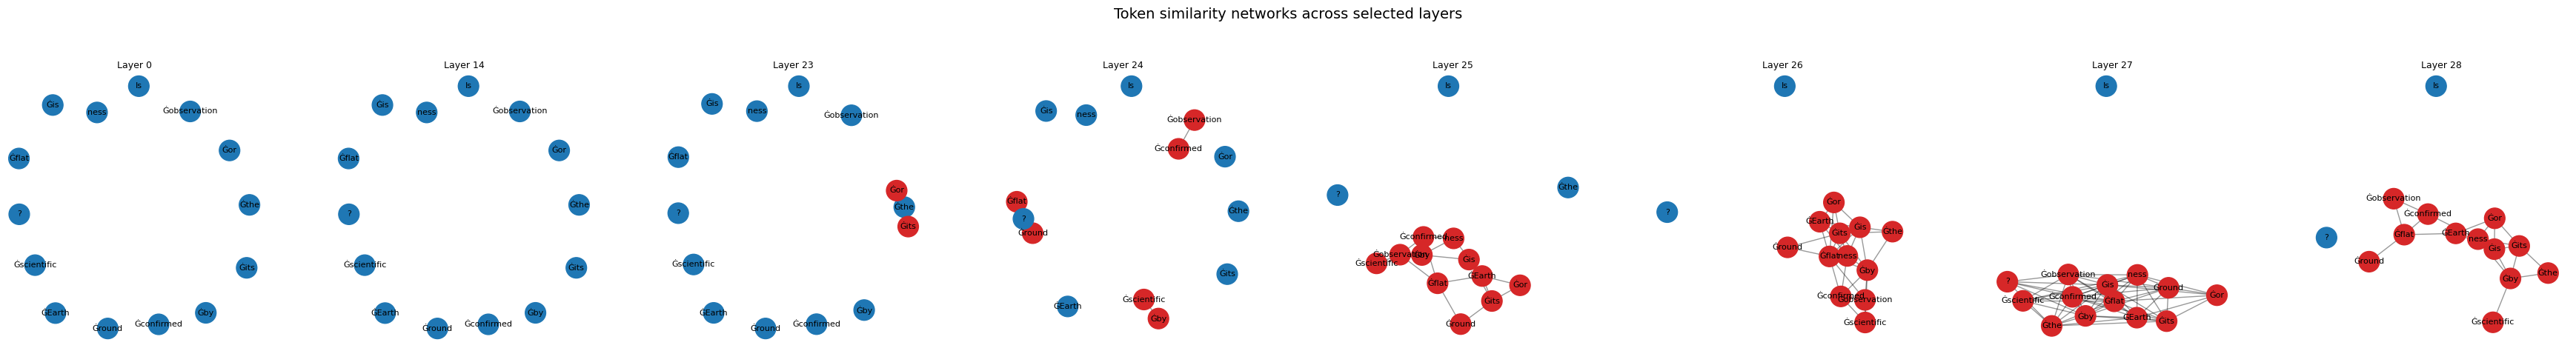

In [7]:
model_id_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]

example_text = CORPUS[0]

key_layers_dict ={
    "gpt2": [0, 2,6,10,11,12],
    "qwen1_5": [0, 2, 6,12,20, 22, 24],
    "qwen2_5": [0, 12, 20, 21, 22, 23, 24],
    "qwen3": [0, 14, 23, 24, 25, 26, 27, 28]
    }


for model_id in model_id_list:

    print(f"\n=== MODEL: {model_id}, THRESHOLD: {DEFAULT_THRESHOLD} ===")

    # Load model + tokenizer
    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    key_layers = key_layers_dict[model_id]

    # Display token representation on key layers
    demo_single_text_networks(
        model,
        tokenizer,
        example_text,
        threshold=0.8,
        layer_indices=key_layers,
    )

# Experiment 1
## Corpus Average Percolation (Default threshold = 0.8)

In [ ]:
model_id_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]

model_results = {}
critical_layers = {}

for model_id in model_id_list:
    print(f"\n=== MODEL: {model_id}, THRESHOLD: {DEFAULT_THRESHOLD} ===")

    # 1. load model + tokenizer
    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    # 2. compute percolation stats (NO CACHE)
    aggregate_stats, all_results = aggregate_over_corpus(
        model=model,
        tokenizer=tokenizer,
        corpus=CORPUS,
        threshold=DEFAULT_THRESHOLD,
        max_length=spec["max_length"],
    )

    model_results[model_id] = aggregate_stats

    # 3. critical layer
    critical_layer = find_critical_layer(
        aggregate_stats,
        phi_threshold=0.7,
        z_cut=1,
    )
    critical_layers[model_id] = critical_layer

    print(f"Critical Layer (model={model_id}): {critical_layer}")

    # 4. summary table
    print("\n" + "=" * 70)
    print(f"SUMMARY STATISTICS – {model_id}, threshold={DEFAULT_THRESHOLD}")
    print("=" * 70)
    print(f"{'Layer':<8} {'Phi (GCC)':<16} {'#Clusters':<15} {'Chi':<15}")
    print("-" * 70)

    for layer, s in aggregate_stats.items():
        print(
            f"{layer:<8} "
            f"{s['phi_mean']:.3f}±{s['phi_std']:.3f}   "
            f"{s['num_clusters_mean']:.1f}±{s['num_clusters_std']:.1f}         "
            f"{s['chi_mean']:.2f}±{s['chi_std']:.2f}"
        )

    print("=" * 70)

    # 5. cleanup
    del model, tokenizer
    if DEVICE == "cuda":
        torch.cuda.empty_cache()



=== MODEL: gpt2, THRESHOLD: 0.8 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Critical Layer (model=gpt2): 11

SUMMARY STATISTICS – gpt2, threshold=0.8
Layer    Phi (GCC)        #Clusters       Chi            
----------------------------------------------------------------------
0        0.288±0.128   11.4±1.7         0.93±0.33
1        0.446±0.174   8.4±2.5         1.13±0.27
2        0.274±0.094   11.3±1.5         1.04±0.27
3        0.226±0.081   12.1±1.3         1.03±0.26
4        0.138±0.071   13.5±2.1         0.70±0.52
5        0.116±0.056   14.1±2.2         0.56±0.54
6        0.105±0.046   14.3±2.0         0.49±0.53
7        0.113±0.048   14.1±2.1         0.58±0.51
8        0.142±0.060   13.4±2.1         0.83±0.43
9        0.180±0.077   12.3±2.3         0.98±0.36
10       0.259±0.121   10.4±2.6         1.14±0.31
11       0.862±0.089   2.9±1.2         1.07±0.20
12       1.000±0.000   1.0±0.0         0.00±0.00

=== MODEL: qwen1_5, THRESHOLD: 0.8 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


Critical Layer (model=qwen1_5): None

SUMMARY STATISTICS – qwen1_5, threshold=0.8
Layer    Phi (GCC)        #Clusters       Chi            
----------------------------------------------------------------------
0        0.089±0.029   14.6±2.2         0.33±0.47
1        0.133±0.060   13.8±2.0         0.65±0.51
2        0.160±0.047   13.4±2.1         0.96±0.28
3        0.161±0.043   13.4±2.2         0.99±0.21
4        0.110±0.057   14.1±2.3         0.42±0.52
5        0.092±0.035   14.4±2.1         0.34±0.47
6        0.082±0.025   14.7±2.2         0.23±0.42
7        0.080±0.022   14.7±2.2         0.20±0.40
8        0.078±0.020   14.8±2.2         0.17±0.37
9        0.074±0.016   14.9±2.2         0.10±0.30
10       0.074±0.016   14.9±2.2         0.10±0.30
11       0.074±0.016   14.9±2.2         0.10±0.30
12       0.074±0.016   14.9±2.3         0.10±0.30
13       0.076±0.018   14.9±2.3         0.13±0.34
14       0.078±0.025   14.8±2.2         0.13±0.34
15       0.082±0.027   14.7±2.2        

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Critical Layer (model=qwen2_5): None

SUMMARY STATISTICS – qwen2_5, threshold=0.8
Layer    Phi (GCC)        #Clusters       Chi            
----------------------------------------------------------------------
0        0.089±0.029   14.6±2.2         0.33±0.47
1        0.089±0.029   14.6±2.2         0.33±0.47
2        0.093±0.032   14.4±2.1         0.37±0.48
3        0.075±0.017   14.8±2.2         0.13±0.34
4        0.075±0.017   14.8±2.2         0.13±0.34
5        0.078±0.022   14.7±2.2         0.17±0.37
6        0.080±0.024   14.7±2.2         0.20±0.40
7        0.078±0.019   14.7±2.2         0.17±0.37
8        0.078±0.019   14.8±2.2         0.17±0.37
9        0.076±0.018   14.8±2.2         0.13±0.34
10       0.076±0.018   14.8±2.2         0.13±0.34
11       0.080±0.024   14.7±2.2         0.20±0.40
12       0.078±0.021   14.8±2.2         0.17±0.37
13       0.092±0.035   14.6±2.3         0.34±0.48
14       0.103±0.036   14.3±2.3         0.53±0.50
15       0.107±0.037   14.2±2.2        

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 30/30 [00:59<00:00,  2.00s/it]


Critical Layer (model=qwen3): 26

SUMMARY STATISTICS – qwen3, threshold=0.8
Layer    Phi (GCC)        #Clusters       Chi            
----------------------------------------------------------------------
0        0.089±0.029   14.6±2.2         0.33±0.47
1        0.089±0.029   14.6±2.2         0.33±0.47
2        0.091±0.029   14.4±2.1         0.37±0.48
3        0.087±0.028   14.6±2.2         0.30±0.46
4        0.085±0.028   14.6±2.2         0.27±0.44
5        0.089±0.031   14.5±2.2         0.32±0.50
6        0.080±0.024   14.6±2.1         0.20±0.40
7        0.082±0.026   14.7±2.2         0.21±0.43
8        0.088±0.030   14.5±2.1         0.30±0.46
9        0.088±0.028   14.6±2.1         0.31±0.48
10       0.090±0.030   14.5±2.1         0.33±0.47
11       0.103±0.042   14.2±2.3         0.48±0.52
12       0.098±0.039   14.4±2.1         0.41±0.51
13       0.103±0.046   14.2±2.3         0.42±0.53
14       0.097±0.043   14.4±2.3         0.37±0.49
15       0.095±0.032   14.4±2.1         0.40±

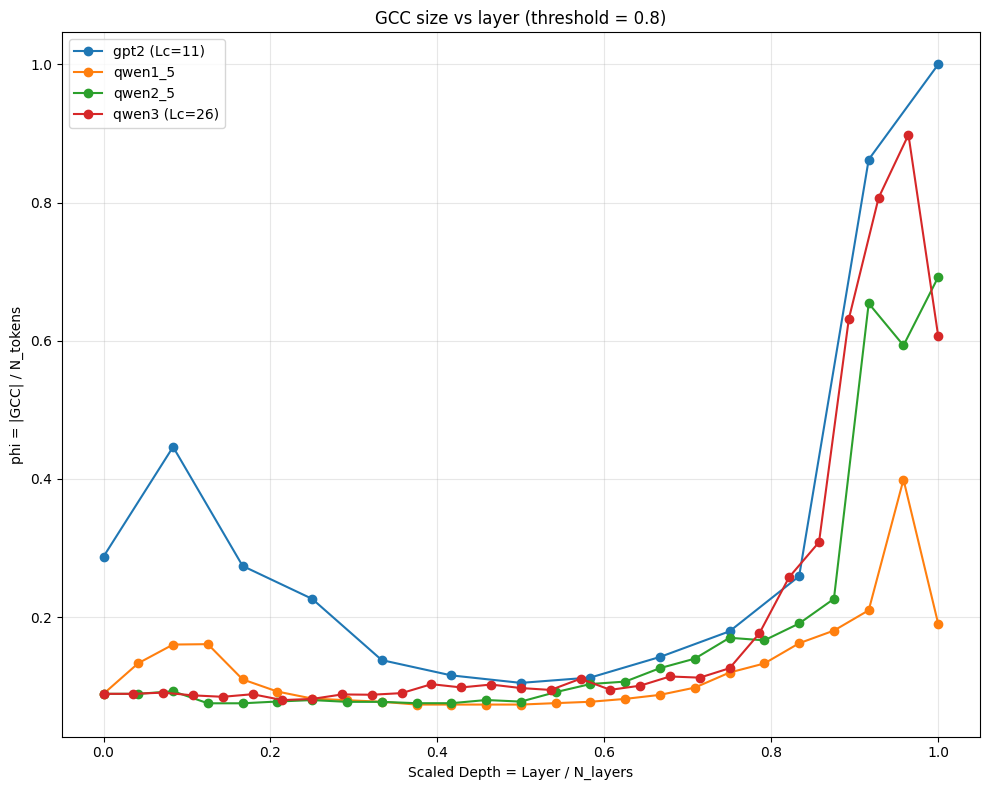

In [ ]:
# 4. plot cross model GCC curves for default threshold
plt.figure(figsize=(10, 8))


for model_id, aggregate in model_results.items():
  layers = sorted(aggregate.keys())
  num_layers = max(layers) + 1
  rel_layers = [l / (num_layers - 1) for l in layers]

  phi_mean = [aggregate[l]["phi_mean"] for l in layers]

  label = model_id
  if critical_layers[model_id] is not None:
      label += f" (Lc={critical_layers[model_id]})"

  plt.plot(rel_layers, phi_mean, marker="o", label=label)

plt.xlabel("Scaled Depth = Layer / N_layers")
plt.ylabel("phi = |GCC| / N_tokens")
plt.title(f"GCC size vs layer (threshold = {DEFAULT_THRESHOLD})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Experiment 2:

## Exeperiment 2a:Threshold Sensitivity Analysis


================ MODEL: gpt2 ================

Loading model: gpt2 on cpu...
=== THRESHOLD: 0.6 ===


Texts: 100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Critical Layer (threshold=0.6): 12
=== THRESHOLD: 0.7 ===


Texts: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]


Critical Layer (threshold=0.7): 1
=== THRESHOLD: 0.8 ===


Texts: 100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Critical Layer (threshold=0.8): 11
=== THRESHOLD: 0.9 ===


Texts: 100%|██████████| 30/30 [00:06<00:00,  4.94it/s]


Critical Layer (threshold=0.9): 12


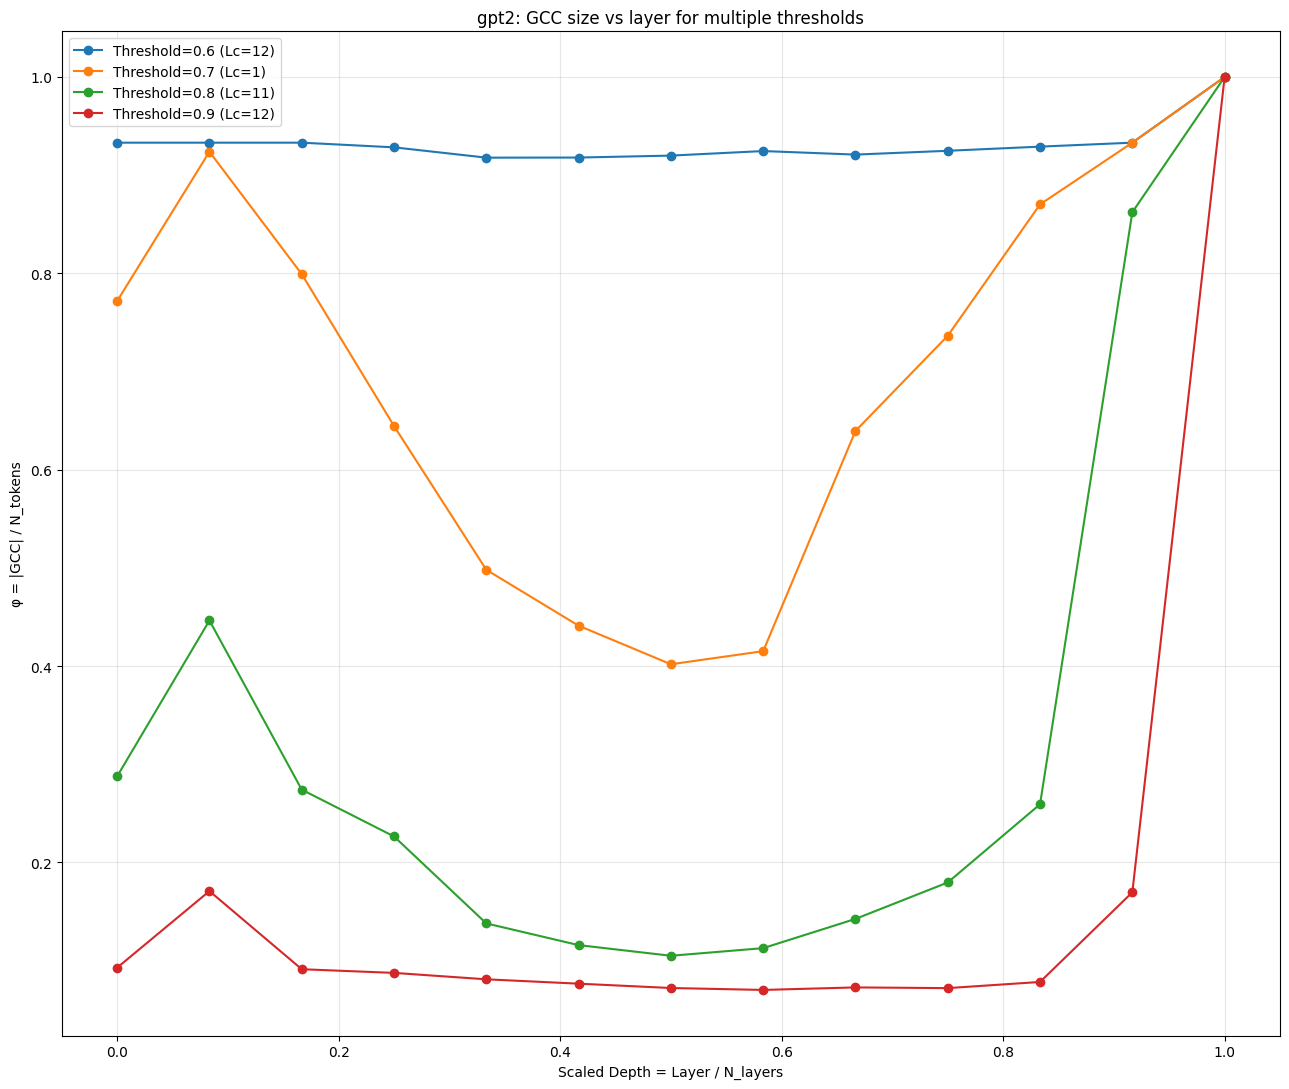


================ MODEL: qwen1_5 ================

Loading model: Qwen/Qwen1.5-0.5B on cpu...
=== THRESHOLD: 0.6 ===


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


Critical Layer (threshold=0.6): 17
=== THRESHOLD: 0.7 ===


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


Critical Layer (threshold=0.7): 23
=== THRESHOLD: 0.8 ===


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


Critical Layer (threshold=0.8): None
=== THRESHOLD: 0.9 ===


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Critical Layer (threshold=0.9): None


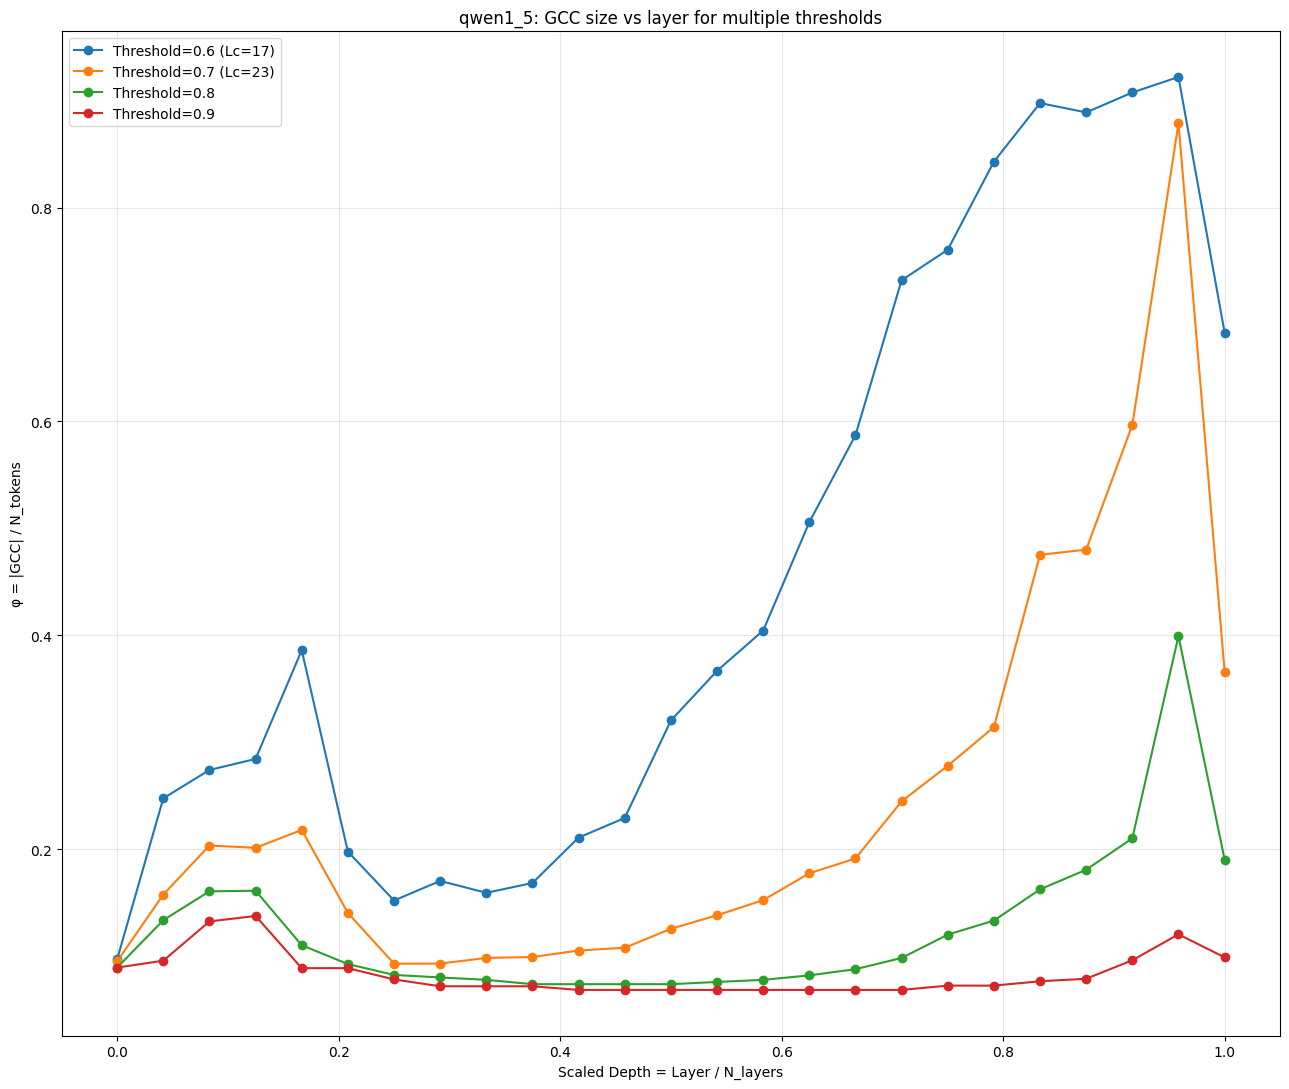


================ MODEL: qwen2_5 ================

Loading model: Qwen/Qwen2.5-0.5B on cpu...
=== THRESHOLD: 0.6 ===


Texts: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


Critical Layer (threshold=0.6): 15
=== THRESHOLD: 0.7 ===


Texts: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


Critical Layer (threshold=0.7): 21
=== THRESHOLD: 0.8 ===


Texts: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


Critical Layer (threshold=0.8): None
=== THRESHOLD: 0.9 ===


Texts: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


Critical Layer (threshold=0.9): None


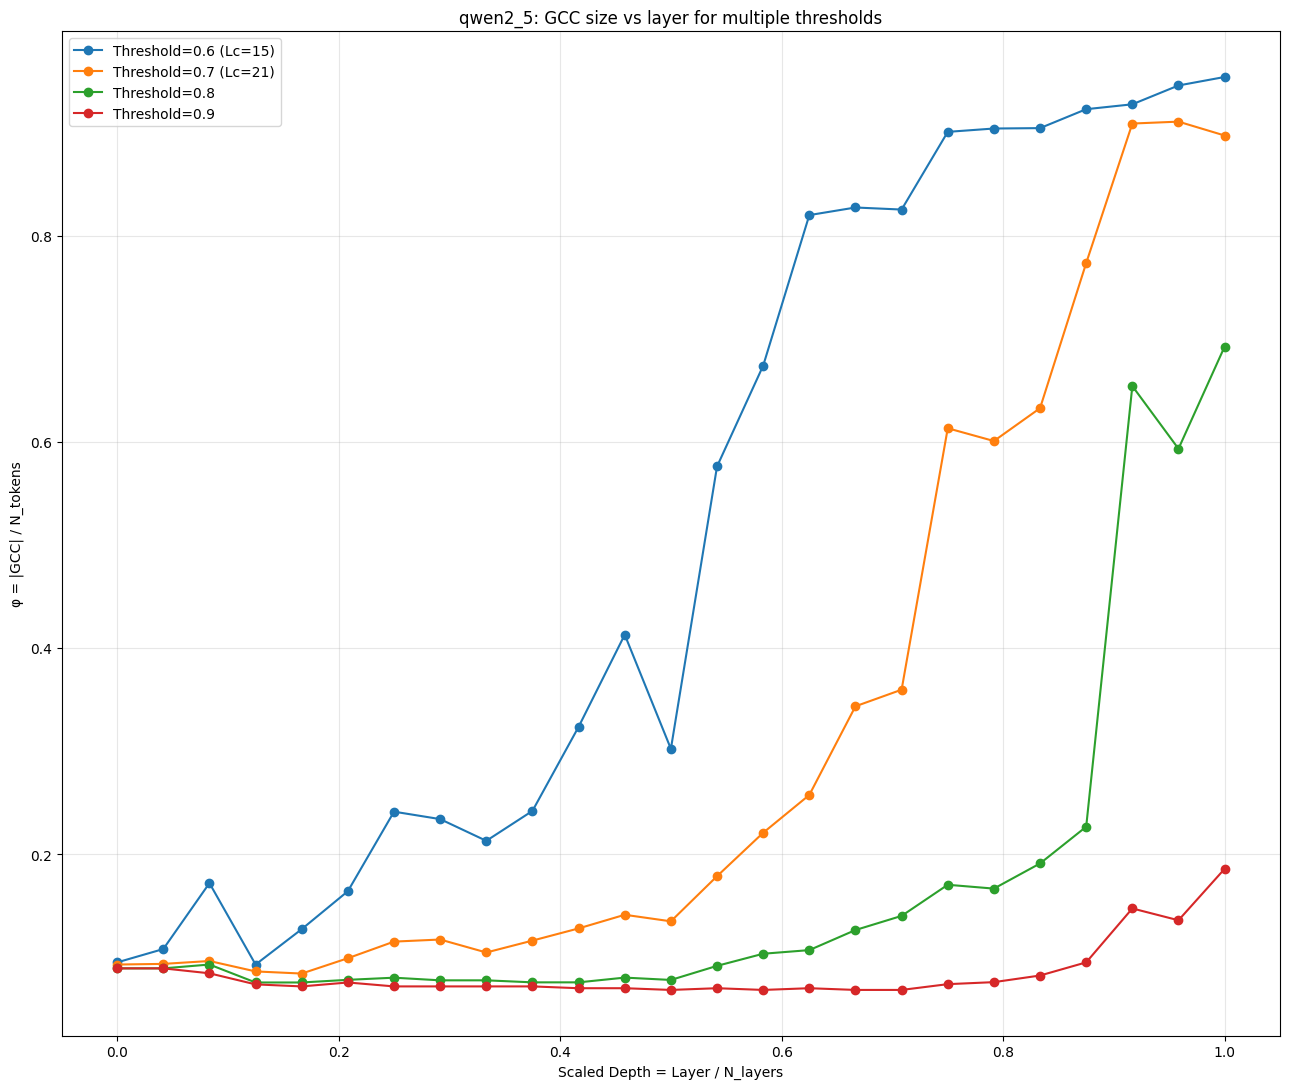


================ MODEL: qwen3 ================

Loading model: Qwen/Qwen3-0.6B-base on cpu...
=== THRESHOLD: 0.6 ===


Texts: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


Critical Layer (threshold=0.6): 11
=== THRESHOLD: 0.7 ===


Texts: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


Critical Layer (threshold=0.7): 23
=== THRESHOLD: 0.8 ===


Texts: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


Critical Layer (threshold=0.8): 26
=== THRESHOLD: 0.9 ===


Texts: 100%|██████████| 30/30 [00:23<00:00,  1.25it/s]


Critical Layer (threshold=0.9): None


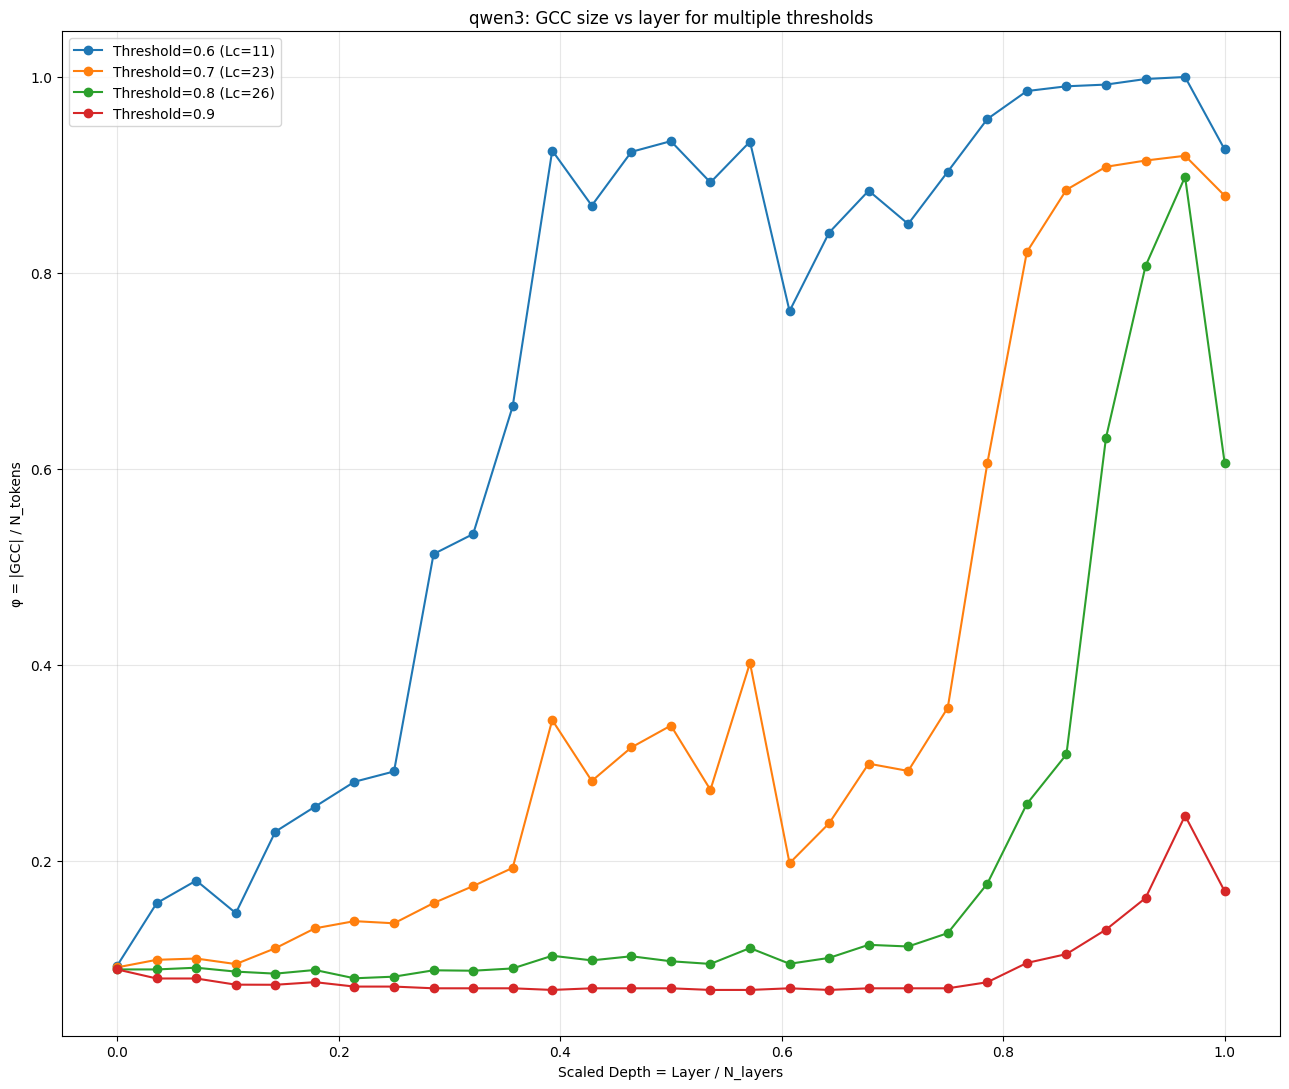

In [ ]:
import matplotlib.pyplot as plt

model_id_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]
threshold_list = [0.6, 0.7, 0.8, 0.9]

for model_id in model_id_list:

    print(f"\n================ MODEL: {model_id} ================\n")

    # 1. load model + tokenizer ONCE
    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    threshold_results = {}   # threshold -> aggregate_stats
    critical_layers = {}     # threshold -> critical_layer

    # 2. sweep thresholds
    for threshold in threshold_list:
        print(f"=== THRESHOLD: {threshold} ===")

        aggregate_stats, _ = aggregate_over_corpus(
            model=model,
            tokenizer=tokenizer,
            corpus=CORPUS,
            threshold=threshold,
            max_length=spec["max_length"],
        )

        threshold_results[threshold] = aggregate_stats

        critical_layer = find_critical_layer(
            aggregate_stats,
            phi_threshold=0.7,
            z_cut=1,
        )
        critical_layers[threshold] = critical_layer

        print(f"Critical Layer (threshold={threshold}): {critical_layer}")

    # 3. plot ONE model, MULTIPLE thresholds
    plt.figure(figsize=(13, 11))

    # layer normalization (shared across thresholds)
    any_agg = next(iter(threshold_results.values()))
    layers = sorted(any_agg.keys())
    num_layers = max(layers) + 1
    rel_layers = [l / (num_layers - 1) for l in layers]

    for threshold in threshold_list:
        aggregate = threshold_results[threshold]
        phi_mean = [aggregate[l]["phi_mean"] for l in layers]

        label = f"Threshold={threshold}"
        if critical_layers[threshold] is not None:
            label += f" (Lc={critical_layers[threshold]})"

        plt.plot(rel_layers, phi_mean, marker="o", label=label)

    plt.xlabel("Scaled Depth = Layer / N_layers")
    plt.ylabel("φ = |GCC| / N_tokens")
    plt.title(f"{model_id}: GCC size vs layer for multiple thresholds")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left", frameon=True, framealpha=0.8)
    plt.tight_layout()
    plt.show()

    # 4. cleanup
    del model, tokenizer
    if DEVICE == "cuda":
        torch.cuda.empty_cache()


## Experiment 2b: Percentile-Based Threshold ( 90th / 95th Percentile )

In [6]:
model_id_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]
percentile_list = [90, 95]

model_thresholds = {}

for model_id in model_id_list:
    print(f"\nCollecting cosine values for model: {model_id}")

    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    all_sims = []

    for text in CORPUS:
        hidden_arrays, _ = extract_hidden_states(
            model,
            tokenizer,
            text,
            max_length=spec["max_length"],
            device=DEVICE,
        )

        for hidden in hidden_arrays:
            sim = compute_similarity_matrix(hidden, use_cosine=USE_COSINE)
            n = sim.shape[0]
            tri_idx = np.triu_indices(n, k=1)
            all_sims.append(sim[tri_idx])

    all_sims = np.concatenate(all_sims)
    print(f"  collected {all_sims.size} similarity values")

    model_thresholds[model_id] = {}
    for p in percentile_list:
        thr = float(np.percentile(all_sims, p))
        model_thresholds[model_id][p] = thr
        print(f"  percentile {p}: threshold = {thr:.4f}")

    # cleanup
    del model, tokenizer
    if DEVICE == "cuda":
        torch.cuda.empty_cache()


Loading model: gpt2 on cpu...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  collected 43745 similarity values
  percentile 90: threshold = 0.8474
  percentile 95: threshold = 0.9752

Loading model: Qwen/Qwen1.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

  collected 82175 similarity values
  percentile 90: threshold = 0.6402
  percentile 95: threshold = 0.7017

Loading model: Qwen/Qwen2.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

  collected 82175 similarity values
  percentile 90: threshold = 0.7065
  percentile 95: threshold = 0.7645

Loading model: Qwen/Qwen3-0.6B-base on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

  collected 95323 similarity values
  percentile 90: threshold = 0.7439
  percentile 95: threshold = 0.7984



========== PERCENTILE 90 ==========

=== MODEL: gpt2, percentile: 90, threshold: 0.8474 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Critical Layer (model=gpt2, p=90): 12

=== MODEL: qwen1_5, percentile: 90, threshold: 0.6402 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


Critical Layer (model=qwen1_5, p=90): None

=== MODEL: qwen2_5, percentile: 90, threshold: 0.7065 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


Critical Layer (model=qwen2_5, p=90): 22

=== MODEL: qwen3, percentile: 90, threshold: 0.7439 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


Texts: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Critical Layer (model=qwen3, p=90): 24


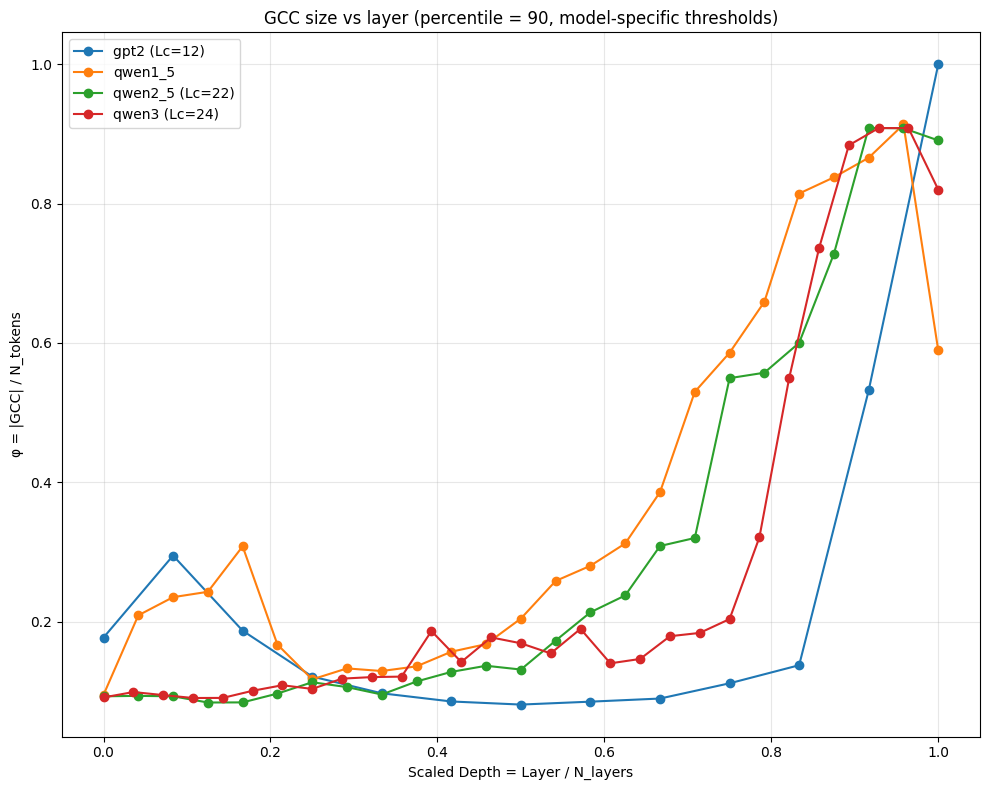


========== PERCENTILE 95 ==========

=== MODEL: gpt2, percentile: 95, threshold: 0.9752 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Critical Layer (model=gpt2, p=95): 12

=== MODEL: qwen1_5, percentile: 95, threshold: 0.7017 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Critical Layer (model=qwen1_5, p=95): 23

=== MODEL: qwen2_5, percentile: 95, threshold: 0.7645 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Critical Layer (model=qwen2_5, p=95): 22

=== MODEL: qwen3, percentile: 95, threshold: 0.7984 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


Texts: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


Critical Layer (model=qwen3, p=95): 26


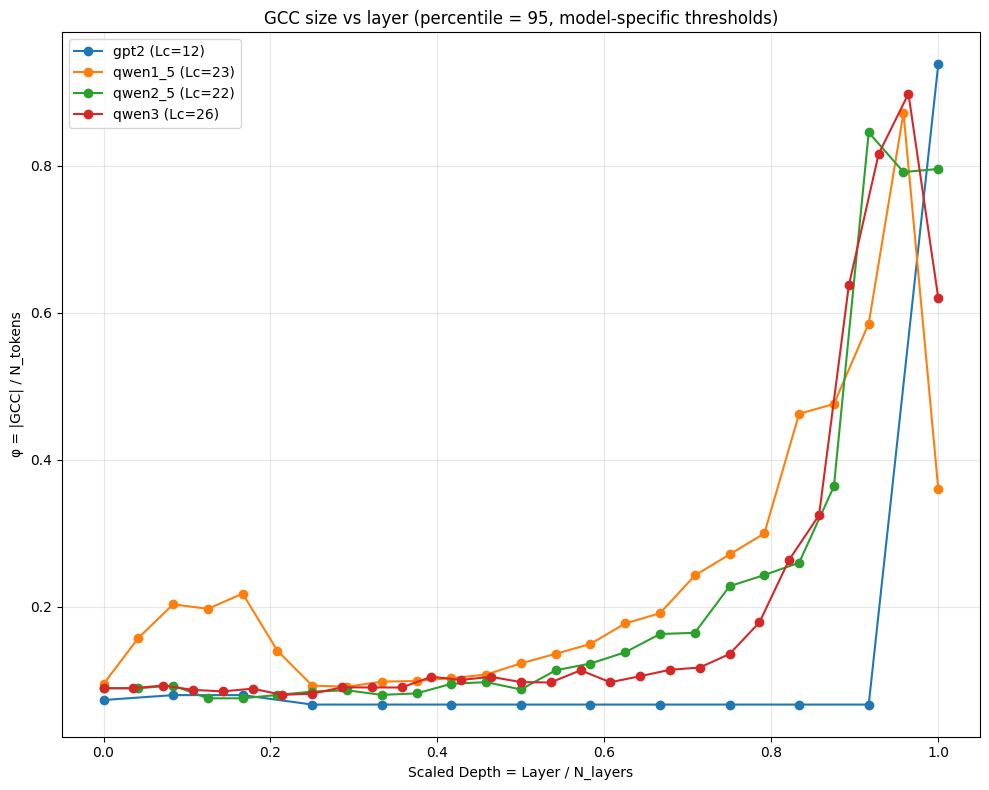

In [7]:
for p in percentile_list:

    print(f"\n========== PERCENTILE {p} ==========")

    model_results = {}
    critical_layers = {}

    for model_id in model_id_list:
        threshold = model_thresholds[model_id][p]
        print(f"\n=== MODEL: {model_id}, percentile: {p}, threshold: {threshold:.4f} ===")

        spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
        model, tokenizer = load_model_and_tokenizer_from_spec(spec)

        # compute percolation stats (NO CACHE)
        aggregate_stats, _ = aggregate_over_corpus(
            model=model,
            tokenizer=tokenizer,
            corpus=CORPUS,
            threshold=threshold,
            max_length=spec["max_length"],
        )

        model_results[model_id] = aggregate_stats

        critical_layer = find_critical_layer(
            aggregate_stats,
            phi_threshold=0.7,
            z_cut=1.5,
        )
        critical_layers[model_id] = critical_layer

        print(f"Critical Layer (model={model_id}, p={p}): {critical_layer}")

        del model, tokenizer
        if DEVICE == "cuda":
            torch.cuda.empty_cache()

    # plot cross-model GCC curves
    plt.figure(figsize=(10, 8))

    for model_id, aggregate in model_results.items():
        layers = sorted(aggregate.keys())
        num_layers = max(layers) + 1
        rel_layers = [l / (num_layers - 1) for l in layers]

        phi_mean = [aggregate[l]["phi_mean"] for l in layers]

        label = model_id
        if critical_layers[model_id] is not None:
            label += f" (Lc={critical_layers[model_id]})"

        plt.plot(rel_layers, phi_mean, marker="o", label=label)

    plt.xlabel("Scaled Depth = Layer / N_layers")
    plt.ylabel("φ = |GCC| / N_tokens")
    plt.title(f"GCC size vs layer (percentile = {p}, model-specific thresholds)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Experiment 3:


## Experiment 3a: Per Text Percolation

In [8]:
def plot_per_prompt_gcc(
    all_results,
    corpus,
    model_id,
    threshold_label=None,
    example_indices=None,
):
    """
    Plot φ vs layer for selected prompts of one model.
    all_results: output from aggregate_over_corpus
    """

    n_layers = len(all_results[0]["layer_stats"])
    layers = list(range(n_layers))

    if example_indices is None:
        example_indices = list(range(min(7, len(all_results))))

    plt.figure(figsize=(14, 10))

    for seq_idx in example_indices:
        seq_layers = all_results[seq_idx]["layer_stats"]

        phi_seq = [seq_layers[l]["phi"] for l in layers]

        text = corpus[seq_idx]
        short = text if len(text) <= 40 else text[:40] + "..."
        label = f"Prompt {seq_idx}: {short}"

        plt.plot(layers, phi_seq, marker="o", linewidth=1.5, label=label)

    plt.xlabel("Layer")
    plt.ylabel("φ = |GCC| / N_tokens")

    title = f"{model_id}: GCC vs Layer"
    if threshold_label is not None:
        title += f" (threshold = {threshold_label})"

    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_model_per_prompt(
    model_id,
    threshold,
    threshold_label=None,
    example_indices=None,
):
    """
    Compute percolation on the fly and plot φ vs layer
    for selected prompts (NO CACHE).
    """

    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    _, all_results = aggregate_over_corpus(
        model=model,
        tokenizer=tokenizer,
        corpus=CORPUS,
        threshold=threshold,
        max_length=spec["max_length"],
    )

    if threshold_label is None:
        threshold_label = f"{threshold:.2f}"

    plot_per_prompt_gcc(
        all_results=all_results,
        corpus=CORPUS,
        model_id=model_id,
        threshold_label=threshold_label,
        example_indices=example_indices,
    )

    del model, tokenizer
    if DEVICE == "cuda":
        torch.cuda.empty_cache()


Loading model: gpt2 on cpu...


Texts: 100%|██████████| 30/30 [02:10<00:00,  4.34s/it]


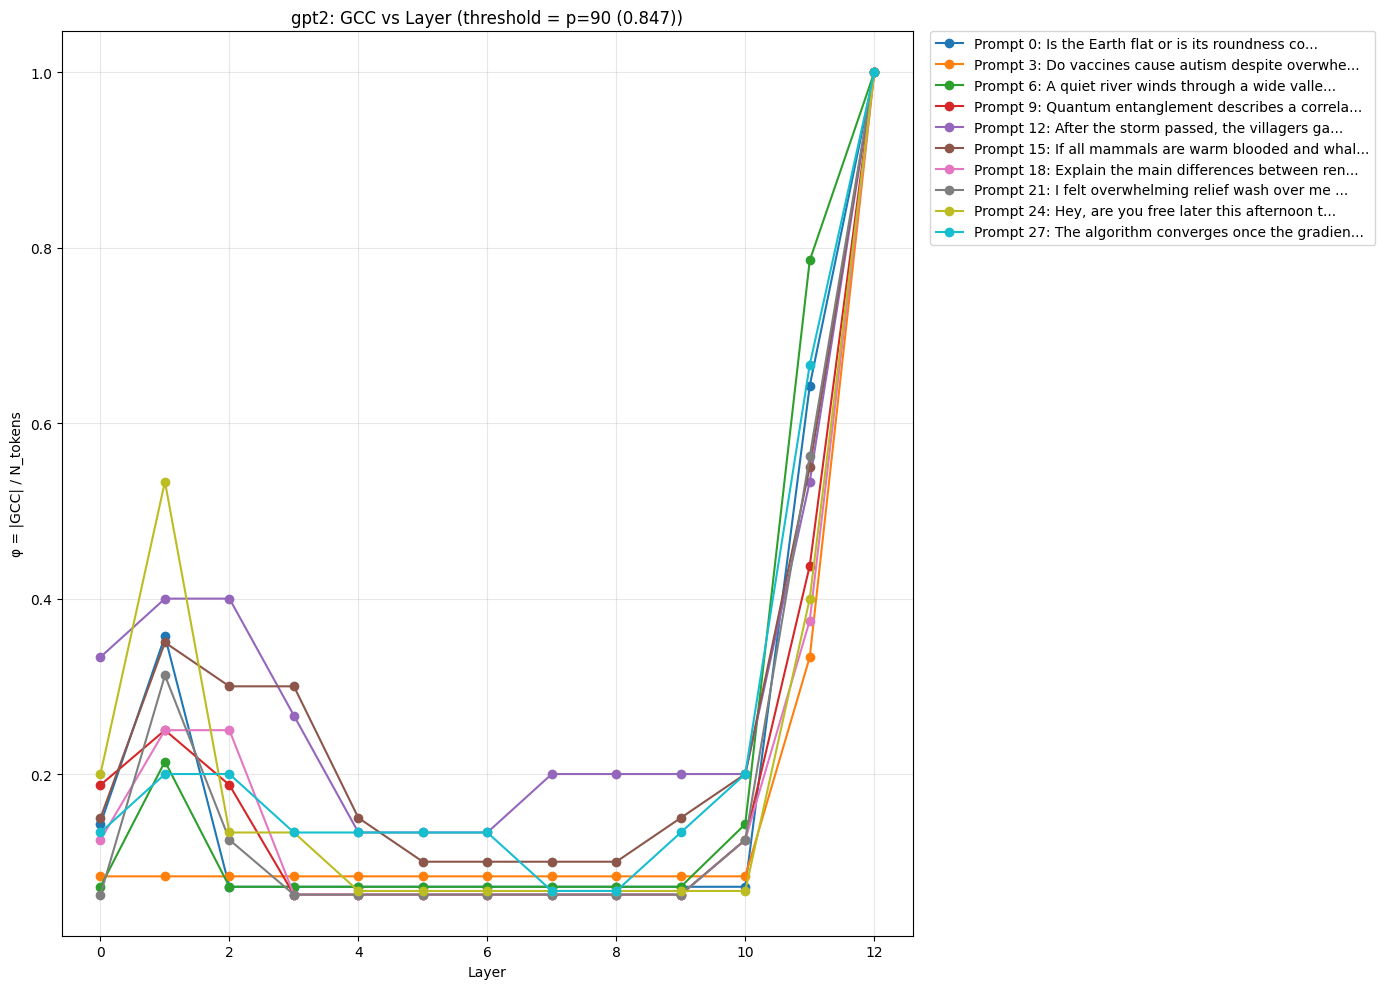

Loading model: Qwen/Qwen1.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


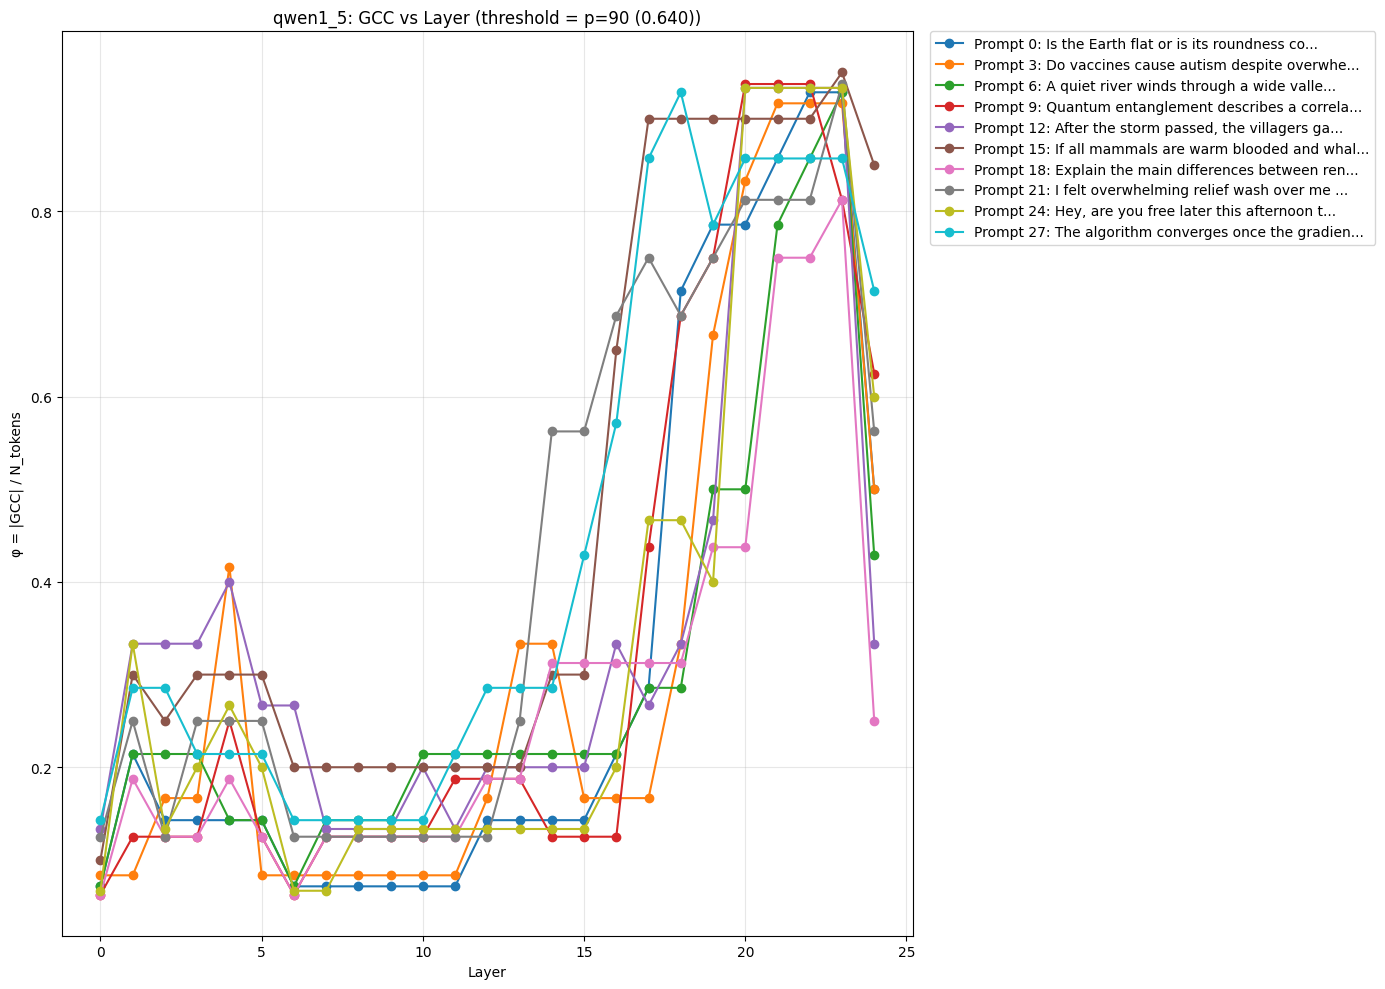

Loading model: Qwen/Qwen2.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


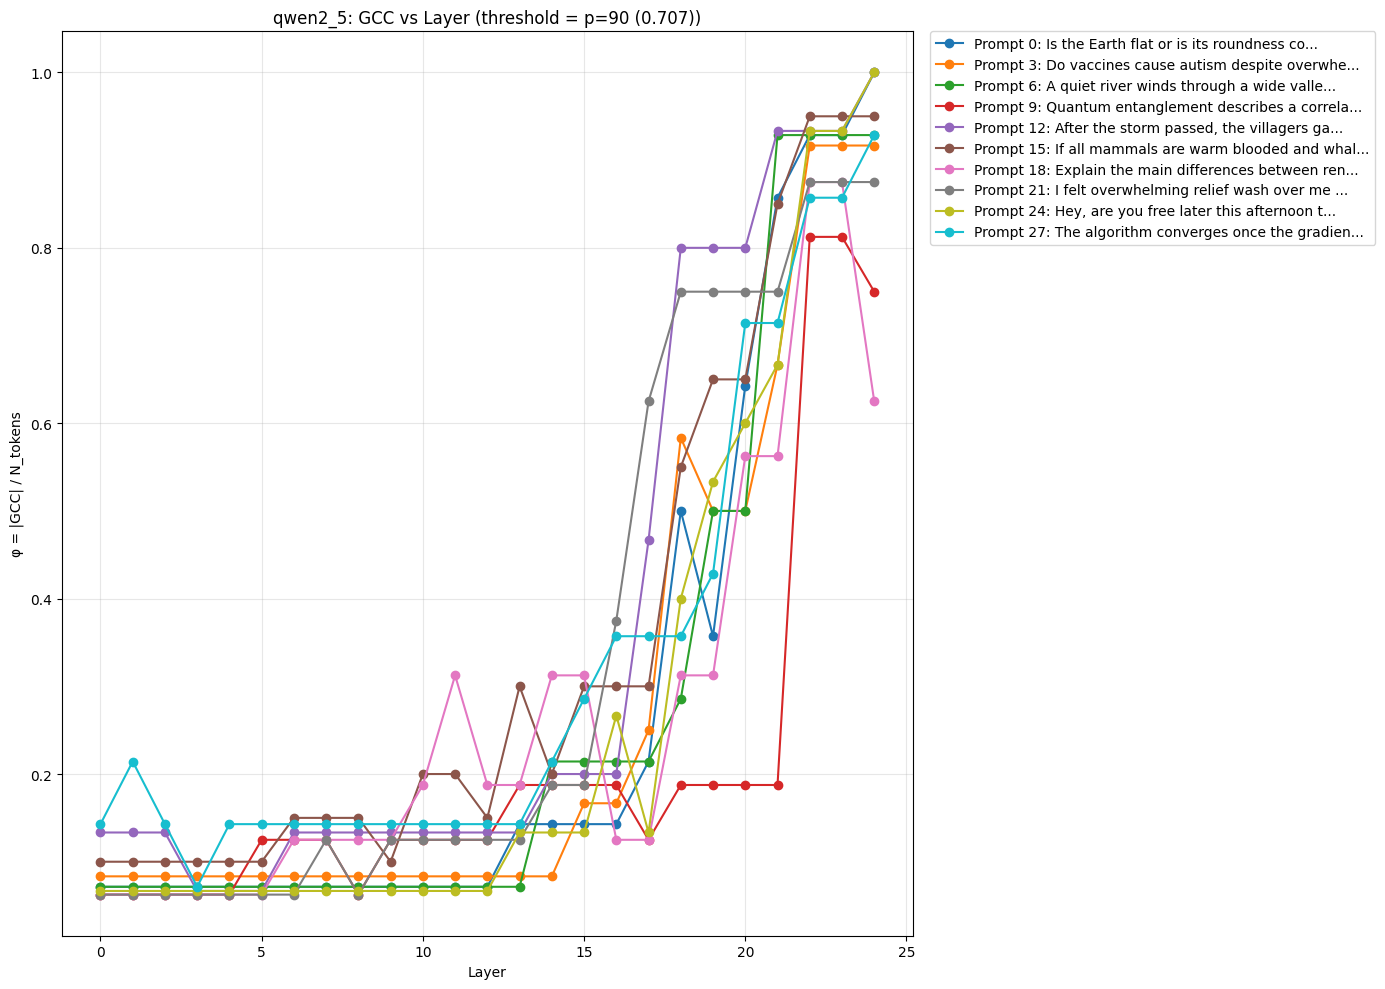

Loading model: Qwen/Qwen3-0.6B-base on cpu...


Texts: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


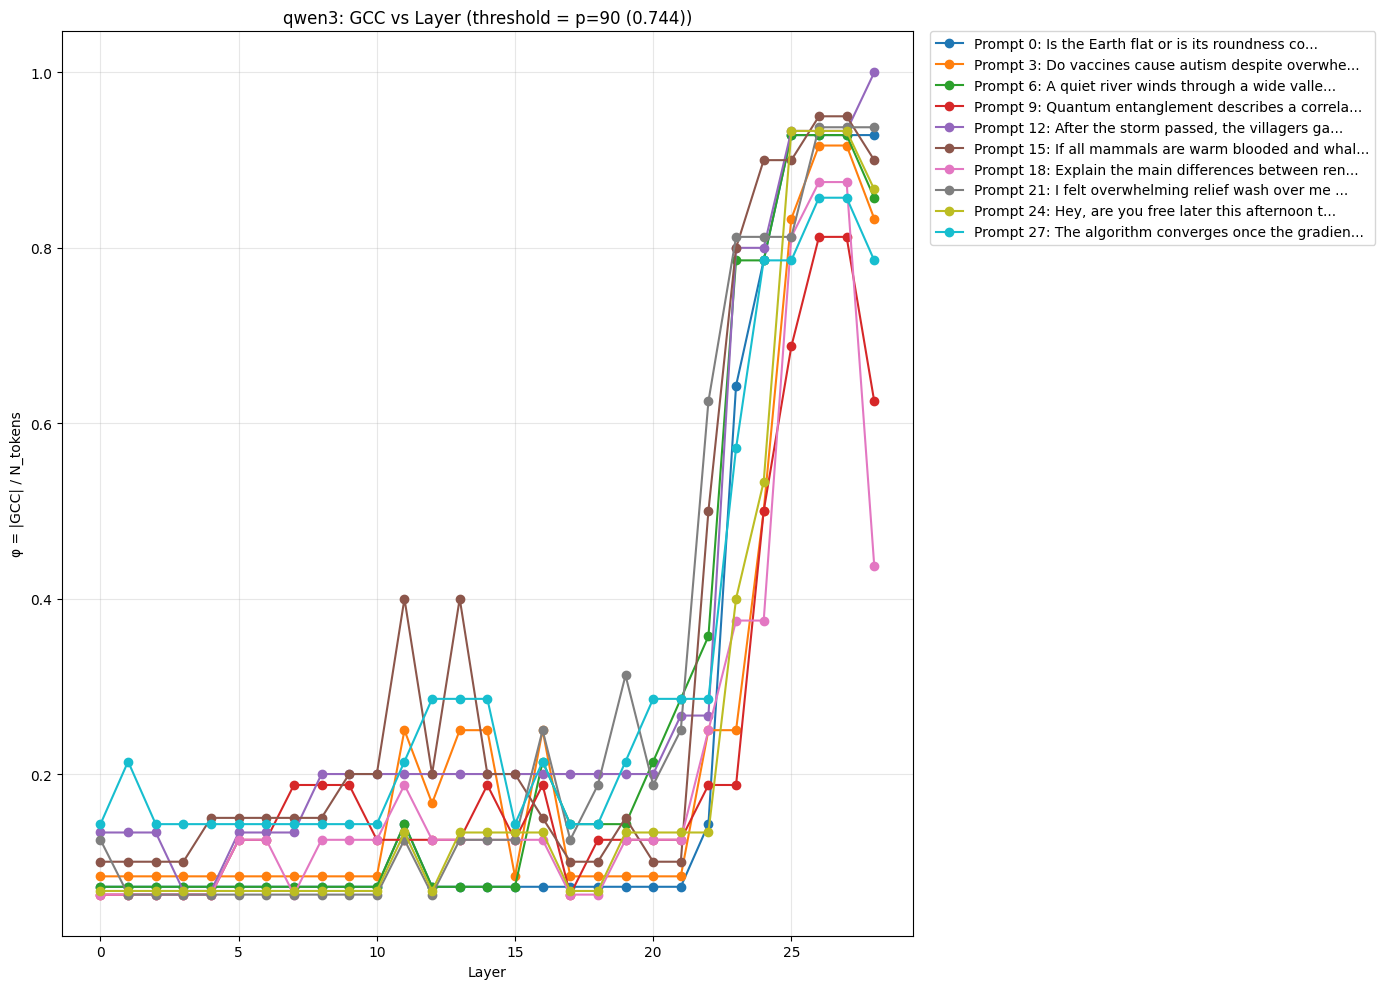

In [10]:
example_indices = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

model_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]

for model_id in model_list:
    thr = model_thresholds[model_id][90]

    plot_model_per_prompt(
        model_id=model_id,
        threshold=thr,
        threshold_label=f"p=90 ({thr:.3f})",
        example_indices=example_indices,
    )

## EXoerument 3b: Bootstrap Stability Analysis

In [15]:
def build_phi_matrix_from_all_results(all_results):
    num_texts = len(all_results)
    num_layers = len(all_results[0]["layer_stats"])

    phi_mat = np.zeros((num_texts, num_layers))
    for i, res in enumerate(all_results):
        for l in range(num_layers):
            phi_mat[i, l] = res["layer_stats"][l]["phi"]

    return phi_mat


def bootstrap_percolation(
    phi_mat,
    num_boot=200,
    phi_threshold=0.7,
    z_cut=1.0,
):
    """
    Bootstrap percolation using the SAME critical-layer definition
    as the cached version.
    """
    num_texts, num_layers = phi_mat.shape

    boot_mean_phi = np.zeros((num_boot, num_layers))
    lc_samples = []

    for b in range(num_boot):
        idx = np.random.randint(0, num_texts, size=num_texts)
        sample = phi_mat[idx]  # [texts, layers]

        # IMPORTANT: compute BOTH mean and std across texts
        mean_phi = sample.mean(axis=0)
        std_phi = sample.std(axis=0)

        boot_mean_phi[b] = mean_phi

        # Rebuild aggregate in the SAME schema
        aggregate_boot = {
            l: {
                "phi_mean": mean_phi[l],
                "phi_std": std_phi[l],
            }
            for l in range(num_layers)
        }

        lc_b = find_critical_layer(
            aggregate_boot,
            phi_threshold=phi_threshold,
            z_cut=z_cut,
        )
        lc_samples.append(lc_b)

    mean_phi_boot = boot_mean_phi.mean(axis=0)
    lower = np.percentile(boot_mean_phi, 2.5, axis=0)
    upper = np.percentile(boot_mean_phi, 97.5, axis=0)

    return mean_phi_boot, lower, upper, np.array(lc_samples)



In [18]:
import numpy as np
import matplotlib.pyplot as plt

# reproducibility
rng = np.random.default_rng(seed=42)

p = 90
model_id_list = ["gpt2", "qwen1_5", "qwen2_5", "qwen3"]

print(f"\n========== PERCENTILE {p} ============")

model_results = {}
critical_layers = {}
critical_layers_std = {}

for model_id in model_id_list:
    threshold = model_thresholds[model_id][p]
    print(f"\n=== MODEL: {model_id}, percentile={p}, threshold={threshold:.4f} ===")

    # 1. load model
    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model_and_tokenizer_from_spec(spec)

    # 2. compute percolation once
    aggregate_stats, all_results = aggregate_over_corpus(
        model=model,
        tokenizer=tokenizer,
        corpus=CORPUS,
        threshold=threshold,
        max_length=spec["max_length"],
    )

    # 3. build φ matrix
    phi_mat = build_phi_matrix_from_all_results(all_results)

    # 4. bootstrap
    mean_phi_boot, lower, upper, lc_samples = bootstrap_percolation(
        phi_mat,
        num_boot=200,
        phi_threshold=0.7,
        z_cut=1.0,
    )

    num_layers = phi_mat.shape[1]

    model_results[model_id] = {
        "mean_phi": mean_phi_boot,
        "lower": lower,
        "upper": upper,
        "num_layers": num_layers,
    }

    # summarize Lc distribution
    lc_valid = lc_samples[lc_samples != None]
    if len(lc_valid) > 0:
        lc_mean = float(np.mean(lc_valid))
        lc_std = float(np.std(lc_valid))
    else:
        lc_mean, lc_std = None, None

    critical_layers[model_id] = lc_mean
    critical_layers_std[model_id] = lc_std

    print(
        f"Bootstrap Lc (model={model_id}, p={p}): "
        f"mean={lc_mean}, std={lc_std}"
    )

    # cleanup
    del model, tokenizer
    if DEVICE == "cuda":
        torch.cuda.empty_cache()


========== PERCENTILE 90 ============

=== MODEL: gpt2, percentile=90, threshold=0.8474 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 30/30 [00:07<00:00,  4.13it/s]


Bootstrap Lc (model=gpt2, p=90): mean=12.0, std=0.0

=== MODEL: qwen1_5, percentile=90, threshold=0.6402 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Bootstrap Lc (model=qwen1_5, p=90): mean=20.0, std=0.0

=== MODEL: qwen2_5, percentile=90, threshold=0.7065 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


Texts: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


Bootstrap Lc (model=qwen2_5, p=90): mean=21.895, std=0.3065534211193866

=== MODEL: qwen3, percentile=90, threshold=0.7439 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


Texts: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]

Bootstrap Lc (model=qwen3, p=90): mean=24.22, std=0.41424630354415964


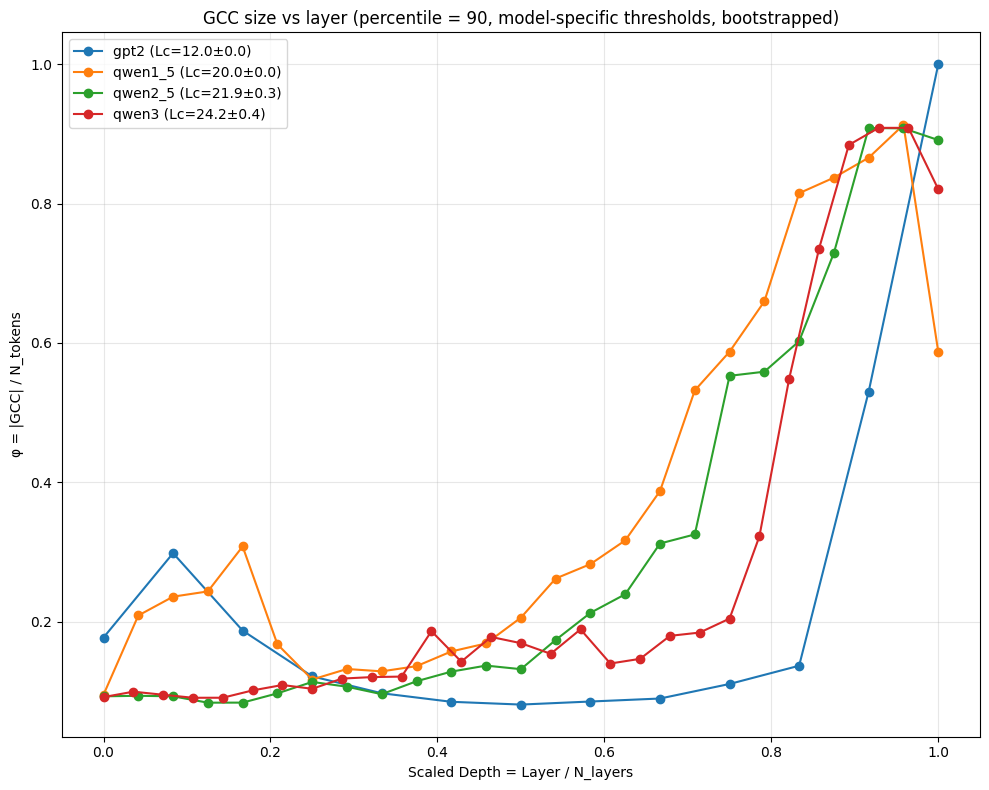

In [19]:
plt.figure(figsize=(10, 8))

for model_id, res in model_results.items():
    num_layers = res["num_layers"]
    layers = list(range(num_layers))
    rel_layers = [l / (num_layers - 1) for l in layers]

    phi_mean = res["mean_phi"]

    label = model_id
    if critical_layers[model_id] is not None:
        label += (
            f" (Lc={critical_layers[model_id]:.1f}"
            f"±{critical_layers_std[model_id]:.1f})"
        )

    plt.plot(rel_layers, phi_mean, marker="o", label=label)

plt.xlabel("Scaled Depth = Layer / N_layers")
plt.ylabel("φ = |GCC| / N_tokens")
plt.title(
    f"GCC size vs layer (percentile = {p}, model-specific thresholds, bootstrapped)"
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
